In [ ]:
# Importación de librerías que se utilizarán
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Support Vector Classifier

## Creación conjuntos de entrenamiento y de validación

In [ ]:
def creacion_dataset(folder):
    
    imagenes = [] # Creacion array de imagenes
    etiquetas = [] # Creacion array de etiquetas
    etiquetas_clases = os.listdir(folder) # Definicion de etiquetas a partir de nombres de carpetas
    
    for etiqueta in etiquetas_clases:
        
        class_path = os.path.join(folder, etiqueta) # Define la ruta de la clase iterada
        if not os.path.isdir(class_path): # Verifica que el folder existe
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name) # Define la ruta de la imagen iterada
            img = cv2.imread(img_path) # Lee la imagen iterada
            if img is not None: # Comprueba que la imagen no es nula 
                img = cv2.resize(img, (64, 64)) # Redimensiona la imagen
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convierte a escala de grises
                img = img.astype("float32") / 255.0 # "Normaliza" la imagen 
                imagenes.append(img.flatten()) # Convierte el arreglo a una dimension y lo agrega al arrelgo imagenes
                etiquetas.append(etiqueta) # Agrega la etiqueta al arreglo de etiquetas
                
    return np.array(imagenes), np.array(etiquetas) # Retorna los arreglos de imagenes y etiquetas

X, Y = creacion_dataset('Direccion carpetas de imagenes') # Llamado de la funcion

le = LabelEncoder() # Se crea el objeto
Y = le.fit_transform(Y) # Se utiliza el metodo fit_transform para reetiquetar el conjunto de etiquetas


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Creacion conjuntos de entrenamiento y de test

print(f'Tamaño de train: {len(X_train)}, Tamaño de test: {len(X_test)}') # Imprime el tamano de los conjuntos de entrenamiento y de test de las imagenes
print(f'Clases codificadas: {le.classes_}')  # Verifica las clases transformadas

Tamaño de train: 12000, Tamaño de test: 3000
Clases codificadas: ['lung_adenocarcinoma' 'lung_benigno' 'lung_carcinoma']


## Definición modelo y entrenamiento

In [ ]:
svm_model = SVC() # Creacion del objeto Support Vector Classifier

# Definicion de parametros a probar
param_grid = {'C': [0.1, 1, 10, 100], 
              "kernel":["linear", "rbf", "poly"],
              'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]}

# Creacion objeto GridSearchCV con parametros definidos y con 5 CV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=4)
# Entrenamiento de posibles modelos
grid_search.fit(X_train, Y_train)

# Ver el mejor valor de C
print(f'Best C: {grid_search.best_params_["C"]}')
print(f'Best kernel: {grid_search.best_params_["kernel"]}')
print(f'Best gamma: {grid_search.best_params_["gamma"]}')

# Evaluar el modelo con el mejor C
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión con el mejor C, kernel y gamma: {accuracy:.2f}')

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 9.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=10.1min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.6min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.6min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.7min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=12.3min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=12.3min
[CV] END ...................

In [ ]:
# Creación modelo con mejores parámetros
mejor_svm = SVC(kernel = "rbf", C=10, gamma=0.01) # Si al ejecutar el código anterior se encuentran mejores valores, estos se reemplazan
mejor_svm.fit(X_train, Y_train)

# Evaluación del mejor modelo
y_pred = mejor_svm.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión con el mejor C y kernel: {accuracy:.2f}')

Precisión con el mejor C y kernel: 0.88


## Evaluación del modelo

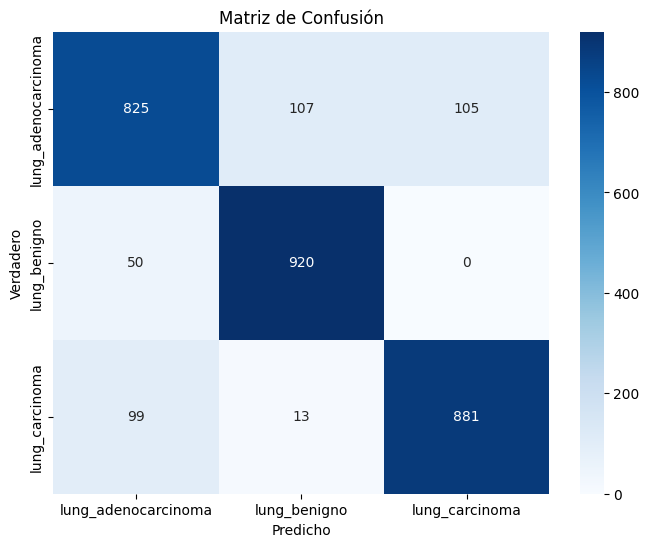

In [ ]:
# Graficación matriz de confusión

# Crear la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

class_labels = le.classes_

# Visualizarla con seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Impresión de reporte de clasificación
print(classification_report(Y_test, y_pred, target_names=le.classes_))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.85      0.80      0.82      1037
       lung_benigno       0.88      0.95      0.92       970
     lung_carcinoma       0.89      0.89      0.89       993

           accuracy                           0.88      3000
          macro avg       0.88      0.88      0.88      3000
       weighted avg       0.87      0.88      0.87      3000

